# Studying a model performance with synthetic data

Synthetic data have been created for each class, using as input the pictures that all models misclassify. The idea is the following: Maybe having more pics similar to the misclassified ones we can improve the performance of the model in that areas.

- There are a test set with 150 real pics of each class.
- The remainder are split into train/val set (80% train)
- For the train set, 480 fake pics have been added to the bathroom class, 250 to the kitchen class (the minority classes), so we have a more balanced dataset


- The study of what pics were generated synthetically can be found here => https://github.com/albertovpd/viu_tfm-deep_vision_classification/tree/synthetic_data_study

- They were created using the pytorch implementation of this repo => https://github.com/mit-han-lab/data-efficient-gans


In [1]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  9 13:23:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [4]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from my_functions202202 import generic_last_2layers, plotting_model, model_evaluation, classification_report_pic, confusion_matrix_report

import numpy as np
%matplotlib inline

# navigating through folder
import os

- paths

In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
train_folder = base_folder + "input/dataset_synth_data-augmented_bathroom_kitchen_20220608/train_ds/"
val_folder = base_folder + "input/dataset_synth_data-augmented_bathroom_kitchen_20220608/val_ds/"
test_folder = base_folder+"input/dataset_synth_data-augmented_bathroom_kitchen_20220608/test_ds/"

src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
#my_functions202202.py

- common parameters

In [7]:
# resolution changed to 224 for every pic
image_size = (224,224)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

In [8]:
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07)
         }

94781440/94765736 [==============================] - 0s 0us/step


In [9]:
train_ds = image_dataset_from_directory(
        train_folder,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )

Found 4338 files belonging to 5 classes.


In [10]:
val_ds = image_dataset_from_directory(
        val_folder,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
      )

Found 902 files belonging to 5 classes.


In [11]:
test_ds = image_dataset_from_directory(
    test_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 750 files belonging to 5 classes.


['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Dinning  =>  train_ds/ 806
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Bedroom  =>  train_ds/ 878
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Kitchen  =>  train_ds/ 902
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Bathroom  =>  train_ds/ 844
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Livingroom  =>  train_ds/ 898
/content/drive/My Drive/2-E

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


34/34 [==============================] - 889s 26s/step - loss: 63.1985 - accuracy: 0.4290 - val_loss: 218.1003 - val_accuracy: 0.2494
Epoch 2/250
34/34 [==============================] - 13s 368ms/step - loss: 278.3768 - accuracy: 0.0083 - val_loss: 162.6062 - val_accuracy: 0.2018
Epoch 3/250
34/34 [==============================] - 12s 357ms/step - loss: 209.8167 - accuracy: 0.1012 - val_loss: 53.7971 - val_accuracy: 0.4091
Epoch 4/250
34/34 [==============================] - 12s 357ms/step - loss: 183.3895 - accuracy: 0.2619 - val_loss: 75.2379 - val_accuracy: 0.4945
Epoch 5/250
34/34 [==============================] - 12s 359ms/step - loss: 88.3561 - accuracy: 0.4182 - val_loss: 35.1546 - val_accuracy: 0.5576
Epoch 6/250
34/34 [==============================] - 12s 359ms/step - loss: 145.9693 - accuracy: 0.3073 - val_loss: 78.8533 - val_accuracy: 0.4290
Epoch 7/250
34/34 [==============================] - 12s 359ms/step - loss: 93.1631 - accuracy: 0.3891 - val_loss: 37.7468 - val_ac

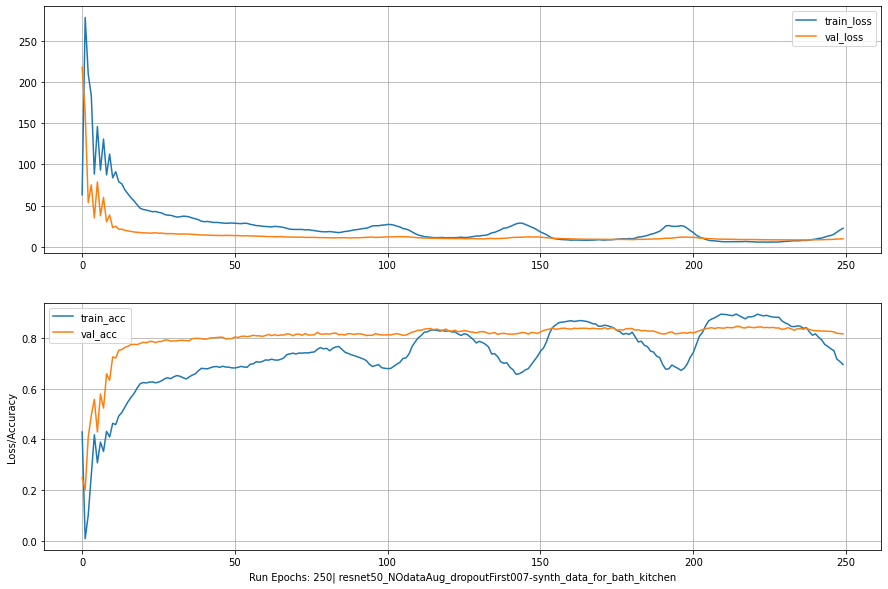

6/6 [==============================] - 149s 25s/step - loss: 9.5948 - accuracy: 0.8093
classification report: resnet50_NOdataAug_dropoutFirst007-synth_data_for_bath_kitchen_trainVal 
               precision    recall  f1-score   support

     Bedroom       0.89      0.93      0.91       211
    Bathroom       0.84      0.94      0.89        82
     Dinning       0.69      0.85      0.76       164
  Livingroom       0.80      0.81      0.81       223
     Kitchen       0.88      0.64      0.74       222

    accuracy                           0.82       902
   macro avg       0.82      0.83      0.82       902
weighted avg       0.82      0.82      0.81       902



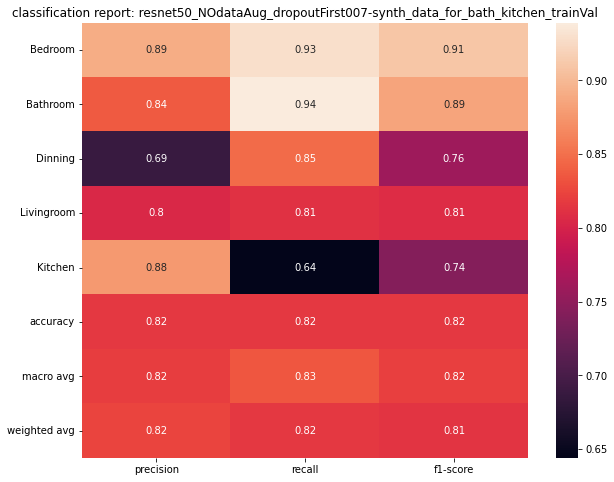

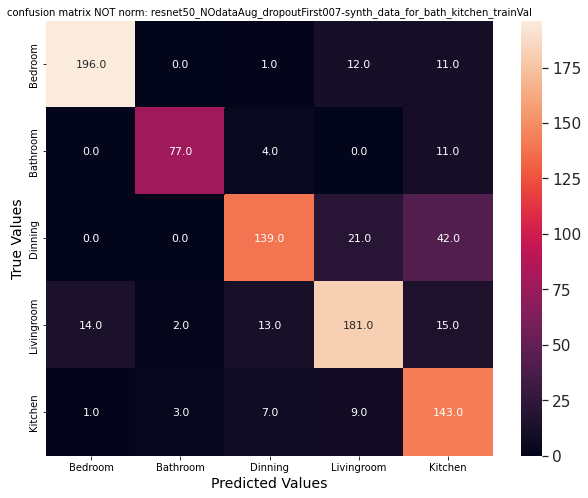

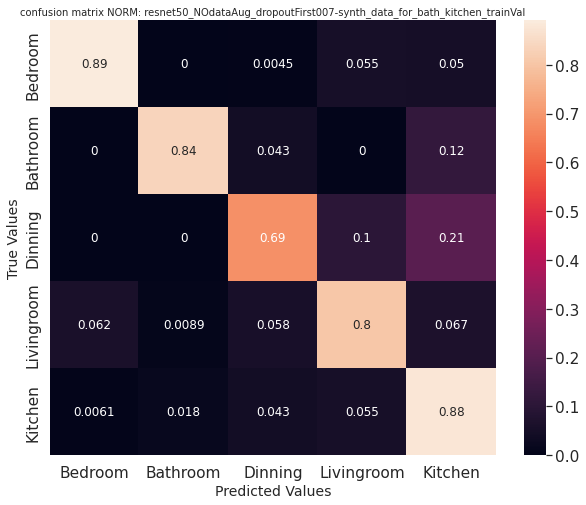

6/6 [==============================] - 2s 318ms/step - loss: 9.5948 - accuracy: 0.8093
classification report: resnet50_NOdataAug_dropoutFirst007-synth_data_for_bath_kitchen_trainTest 
               precision    recall  f1-score   support

     Bedroom       0.83      0.89      0.86       139
    Bathroom       0.84      0.92      0.88       137
     Dinning       0.70      0.85      0.77       124
  Livingroom       0.82      0.77      0.79       160
     Kitchen       0.86      0.68      0.76       190

    accuracy                           0.81       750
   macro avg       0.81      0.82      0.81       750
weighted avg       0.82      0.81      0.81       750



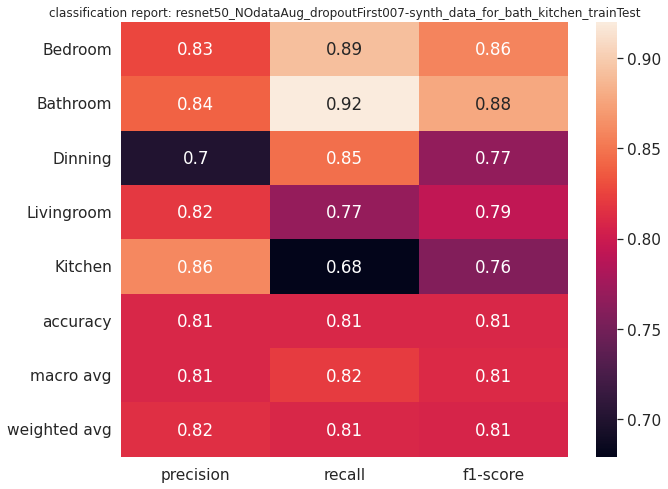

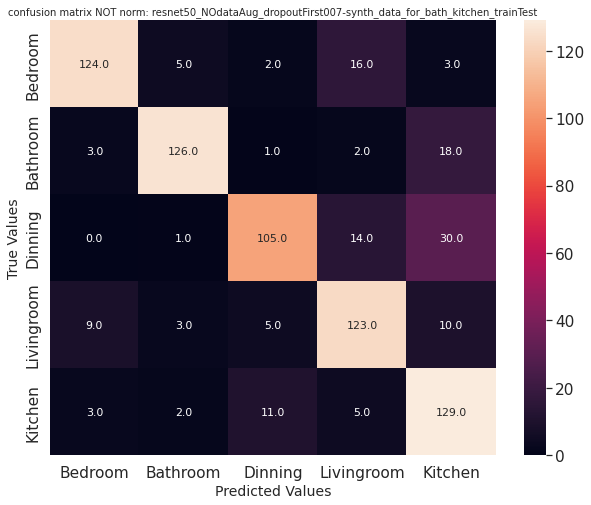

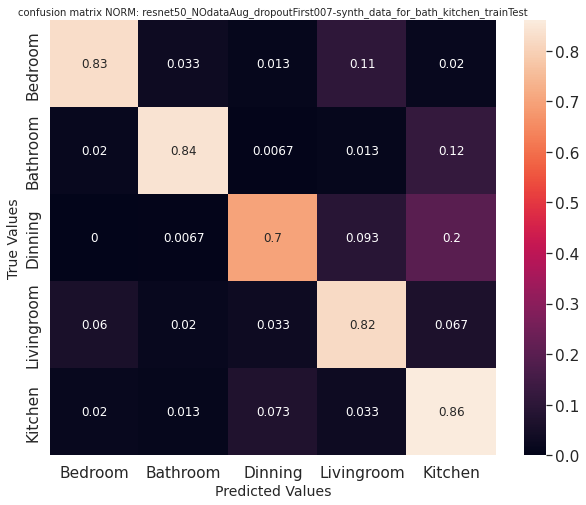

In [12]:
class_names = train_ds.class_names
print(class_names)

# checking numbers non sense now because all have same volume
paths = ['train_ds/', 'val_ds/', "test_ds/"]
for p in paths:
    for dir,subdir,files in os.walk(base_folder + "input/dataset_synth_data-augmented_bathroom_kitchen/"+p):
        print(dir,' => ', p, str(len(files)))

# calling model
model_name, nn = list(models_dict.items())[0]
print("\n", model_name)
nn.summary()

nn.compile( optimizer = opt, #"adam", 
              loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
              metrics=['accuracy'] # "recall"
              )

# ====== USING VAL DATASET ======

history = nn.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      #callbacks = callbacks # <=== REMOVE CALLBACK for full results
      )

number_of_epochs_it_ran = len(history.history['loss']) 
print("run epochs: ",number_of_epochs_it_ran)
name = model_name+"-synth_data_for_bath_kitchen"
#models_dict[m].save(output_folder+name+".h5")

# saving model accuracy/loss graph
plotting_model(history,number_of_epochs_it_ran, name, output_folder, "val") 

# saving model metrics to json
evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
model_evaluation(evaluation, output_folder, name+"_trainVal")

# get inferences
y_pred_val_float = nn.predict(val_ds)
y_pred_val = np.argmax(y_pred_val_float, axis=1)

# get real labels
y_target = tf.concat([y for x, y in val_ds], axis=0) 

# classification and confusion matrix reports
classification_report_pic(y_pred_val, y_target,  class_names, output_folder, name+"_trainVal")
confusion_matrix_report(y_pred_val, y_target, class_names, output_folder, name+"_trainVal")

# ====== USING TEST DATASET ======

# saving model metrics to json
evaluation_test = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
model_evaluation(evaluation_test, output_folder, name+"_trainTest")

# get inferences
y_pred_test_float = nn.predict(test_ds)
y_pred_test = np.argmax(y_pred_test_float, axis=1)

# get real labels for val_ds
y_target_test = tf.concat([y for x, y in test_ds], axis=0) 

# classification and confusion matrix reports
classification_report_pic(y_pred_test, y_target_test,  class_names, output_folder, name+"_trainTest")
confusion_matrix_report(y_pred_test, y_target_test, class_names, output_folder, name+"_trainTest")